### Import statements

In [40]:
import sys
from sklearn import metrics
import pandas as pd
import numpy as np
%matplotlib inline
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib



params = {'legend.fontsize': 'x-large',
          'figure.figsize': (20.0, 10.0),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':30,
         'ytick.labelsize':'x-large'}
matplotlib.rcParams.update(params)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Read inputs

In [2]:
#Load files
pdf = pd.read_csv("submission.csv")
tdf = pd.read_csv("test_private_expanded.csv")
#Get target and predicted
y_true = tdf.toxicity
y_pred = pdf.prediction
y_bin_true = (y_true >= .5) 
y_bin_pred = (y_pred >= .5) 

### Build logistic regression on data and our model prediction

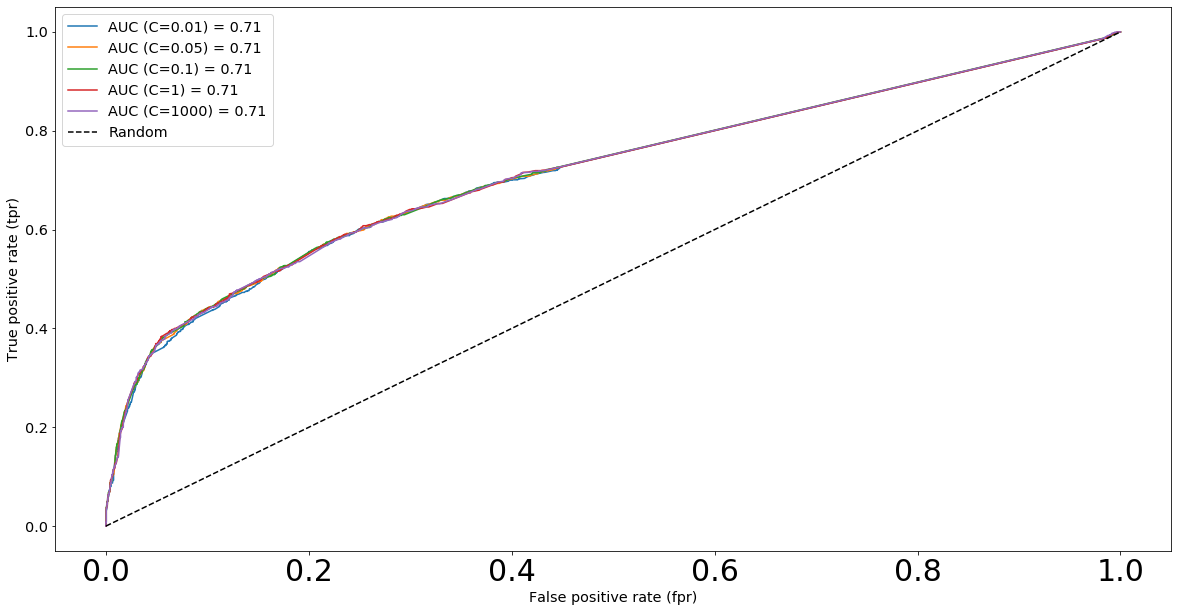

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

race_known = tdf.identity_annotator_count > 0
tdfn = tdf[race_known]
y_predn = y_bin_pred[race_known]
#Split train and test
X_train, X_test, Y_train, Y_test = train_test_split(tdfn.iloc[:,21:], y_predn, test_size=.2)

# Fit a logistic regression model
for c in [0.01, 0.05, .1, 1,1000]:
    model = LogisticRegression(C=c, solver='liblinear')
    model.fit(X_train, Y_train)

    # Get the probability of Y_test records being = 1
    Y_test_probability_1 = model.predict_proba(X_test)[:, 1]

    # Use the metrics.roc_curve function to get the true positive rate (tpr) and false positive rate (fpr)
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_test_probability_1)
    
    # Get the area under the curve (AUC)
    auc = np.mean(cross_val_score(model, X_train, Y_train, scoring="roc_auc", cv=5))

    # Plot the ROC curve
    plt.plot(fpr, tpr, label="AUC (C=" + str(c) + ") = " + str(round(auc, 2)))
    
plt.xlabel("False positive rate (fpr)")
plt.ylabel("True positive rate (tpr)")
plt.plot([0,1], [0,1], 'k--', label="Random")
plt.legend(loc='best')

### Notice that the weights are disproportionally distributed

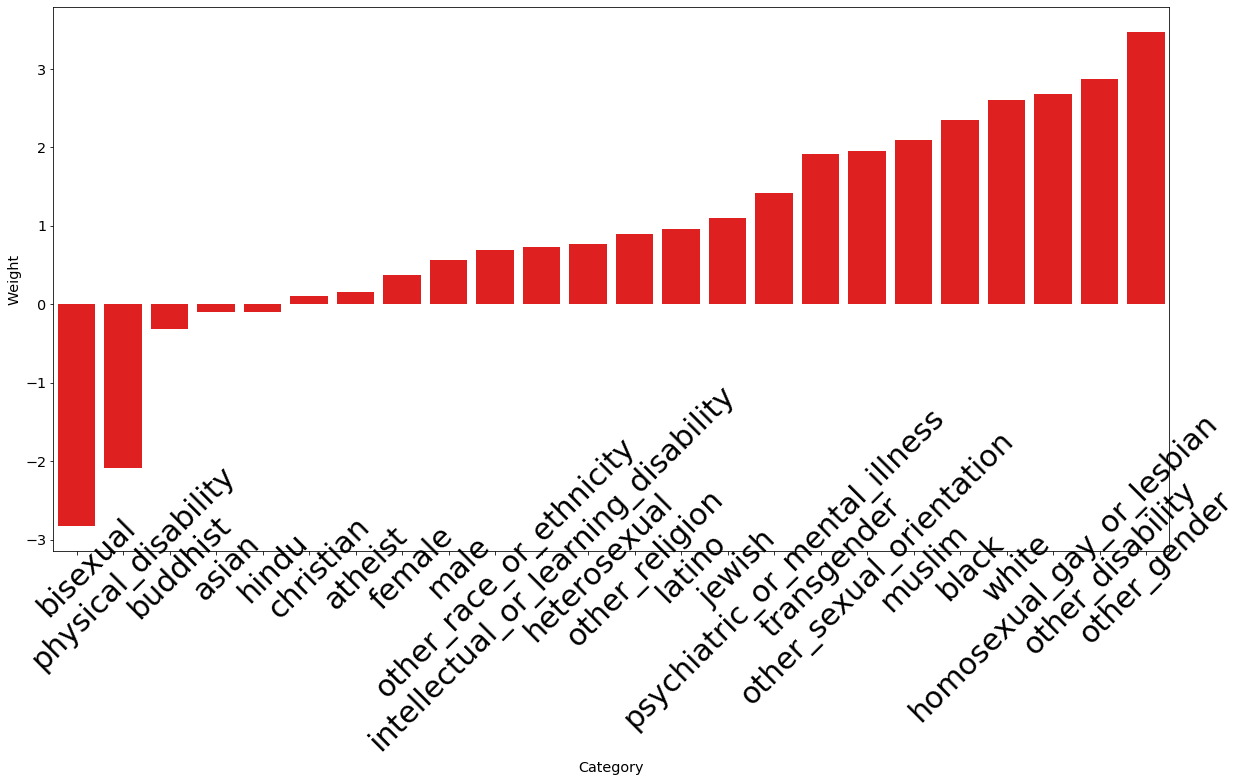

In [5]:
df = pd.DataFrame(zip(model.coef_[0], tdfn.iloc[:,21:].columns.values),columns = ["Weight","Category"])
#df.index = df["Category"]
df = df.sort_values(by="Weight")
#df = df.drop(["Category"],axis = 1)
ax = sns.barplot(x="Category",y="Weight",data=df,color="red",orient="v")
_ = ax.set_xticklabels(df.Category, rotation=45, rotation_mode="anchor")

In [124]:
SUBGROUP_AUC = 'subgroup_auc'
BPSN_AUC = 'bpsn_auc'  # stands for background positive, subgroup negative
BNSP_AUC = 'bnsp_auc'  # stands for background negative, subgroup positive

def compute_auc(y_true, y_pred):
    try:
        return metrics.roc_auc_score(y_true, y_pred)
    except ValueError:
        return np.nan

def compute_subgroup_auc(df, subgroup, label, model_name):
    subgroup_examples = df[df[subgroup]]
    return compute_auc(subgroup_examples[label], subgroup_examples[model_name])

def compute_bpsn_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup negative examples and the background positive examples."""
    subgroup_negative_examples = df[df[subgroup] & ~df[label]]
    non_subgroup_positive_examples = df[~df[subgroup] & df[label]]
    examples = subgroup_negative_examples.append(non_subgroup_positive_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bnsp_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup positive examples and the background negative examples."""
    subgroup_positive_examples = df[df[subgroup] & df[label]]
    non_subgroup_negative_examples = df[~df[subgroup] & ~df[label]]
    examples = subgroup_positive_examples.append(non_subgroup_negative_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bias_metrics_for_model(dataset,
                                   subgroups,
                                   model,
                                   label_col,
                                   include_asegs=False):
    """Computes per-subgroup metrics for all subgroups and one model."""
    records = []
    for subgroup in subgroups:
        record = {
            'subgroup': subgroup,
            'subgroup_size': len(dataset[dataset[subgroup]])
        }
        record[SUBGROUP_AUC] = compute_subgroup_auc(dataset, subgroup, label_col, model)
        record[BPSN_AUC] = compute_bpsn_auc(dataset, subgroup, label_col, model)
        record[BNSP_AUC] = compute_bnsp_auc(dataset, subgroup, label_col, model)
        records.append(record)
    return pd.DataFrame(records).sort_values('subgroup_auc', ascending=True)



######
def calculate_overall_auc(df, model_name):
    true_labels = df[TOXICITY_COLUMN]
    predicted_labels = df[model_name]
    return metrics.roc_auc_score(true_labels, predicted_labels)

def power_mean(series, p):
    total = sum(np.power(series, p))
    return np.power(total / len(series), 1 / p)

def get_final_metric(bias_df, overall_auc, POWER=-5, OVERALL_MODEL_WEIGHT=0.25):
    bias_score = np.average([
        power_mean(bias_df[SUBGROUP_AUC], POWER),
        power_mean(bias_df[BPSN_AUC], POWER),
        power_mean(bias_df[BNSP_AUC], POWER)
    ])
    return (OVERALL_MODEL_WEIGHT * overall_auc) + ((1 - OVERALL_MODEL_WEIGHT) * bias_score)
    
#####
def convert_to_bool(df, col_name):
    df[col_name] = np.where(df[col_name] >= 0.5, True, False)
    
def convert_dataframe_to_bool(df):
    bool_df = df.copy()
    for col in ['toxicity'] + identity_columns:
        convert_to_bool(bool_df, col)
    return bool_df
#####
identity_columns = [
    'male', 'female', 'transgender',
       'other_gender', 'heterosexual', 'homosexual_gay_or_lesbian', 'bisexual',
       'other_sexual_orientation', 'christian', 'jewish', 'muslim', 'hindu',
       'buddhist', 'atheist', 'other_religion', 'black', 'white', 'asian',
       'latino', 'other_race_or_ethnicity', 'physical_disability',
       'intellectual_or_learning_disability', 'psychiatric_or_mental_illness',
       'other_disability']

tdf["pred"] = pdf.prediction
bdf = convert_dataframe_to_bool(tdf)
bias_metrics_df = compute_bias_metrics_for_model(bdf, identity_columns, "pred", "toxicity")


### Look at the official competition bias metrics, both for toxicity and severe toxicity   

#### Regular toxicity

In [121]:
# Sort over regular toxicity

def select_sort(df,col,**kwargs):
    ndf = df.sort_values(by=col,**kwargs)
    return ndf[["subgroup","subgroup_size",col]]

bmetrics = {
    #"subgroup_size":"Size of the subgroup",
    "subgroup_auc":"A low value in this metric means the model does a poor job of distinguishing between toxic and non-toxic comments that mention the identity.",
    "bpsn_auc":"A low value in this metric means that the model confuses non-toxic examples that mention the identity with toxic examples that do not, likely meaning that the model predicts higher toxicity scores than it should for non-toxic examples mentioning the identity.",
    "bnsp_auc":"A low value here means that the model confuses toxic examples that mention the identity with non-toxic examples that do not, likely meaning that the model predicts lower toxicity scores than it should for toxic examples mentioning the identity."
}

for metric in bmetrics:
    print("####")
    print(metric)
    print(bmetrics[metric])
    select_sort(bias_metrics_df,metric,ascending = True).head(10)
    print("####")

bias_metrics_df

####
subgroup_auc
A low value in this metric means the model does a poor job of distinguishing between toxic and non-toxic comments that mention the identity.


,subgroup,subgroup_size,subgroup_auc
11,hindu,28,0.557692
12,buddhist,27,0.600000
5,homosexual_gay_or_lesbian,538,0.786395
4,heterosexual,66,0.791071
2,transgender,129,0.795168
18,latino,121,0.800000
15,black,761,0.812172
16,white,1178,0.819073
9,jewish,411,0.837074
10,muslim,1054,0.847773


####
####
bpsn_auc
A low value in this metric means that the model confuses non-toxic examples that mention the identity with toxic examples that do not, likely meaning that the model predicts higher toxicity scores than it should for non-toxic examples mentioning the identity.


,subgroup,subgroup_size,bpsn_auc
15,black,761,0.758740
4,heterosexual,66,0.760800
16,white,1178,0.762853
5,homosexual_gay_or_lesbian,538,0.766908
19,other_race_or_ethnicity,16,0.770192
2,transgender,129,0.788177
10,muslim,1054,0.794469
18,latino,121,0.802001
6,bisexual,21,0.824129
9,jewish,411,0.827531


####
####
bnsp_auc
A low value here means that the model confuses toxic examples that mention the identity with non-toxic examples that do not, likely meaning that the model predicts lower toxicity scores than it should for toxic examples mentioning the identity.


,subgroup,subgroup_size,bnsp_auc
11,hindu,28,0.754473
12,buddhist,27,0.760495
8,christian,2109,0.899123
13,atheist,149,0.907331
17,asian,217,0.918084
1,female,2602,0.923670
9,jewish,411,0.927052
18,latino,121,0.932913
2,transgender,129,0.934172
22,psychiatric_or_mental_illness,238,0.936369


####


,subgroup,subgroup_size,subgroup_auc,bpsn_auc,bnsp_auc
11,hindu,28,0.557692,0.843500,0.754473
12,buddhist,27,0.600000,0.861482,0.760495
5,homosexual_gay_or_lesbian,538,0.786395,0.766908,0.937261
4,heterosexual,66,0.791071,0.760800,0.942787
2,transgender,129,0.795168,0.788177,0.934172
18,latino,121,0.800000,0.802001,0.932913
15,black,761,0.812172,0.758740,0.949821
16,white,1178,0.819073,0.762853,0.950426
9,jewish,411,0.837074,0.827531,0.927052
10,muslim,1054,0.847773,0.794469,0.944290


#### Severe

In [125]:
sbdf = bdf.copy()
sbdf["severe_toxicity"] = sbdf["severe_toxicity"] > 0
bias_metrics_df = compute_bias_metrics_for_model(sbdf, identity_columns, "pred", "severe_toxicity")

for metric in bmetrics:
    print("####")
    print(metric)
    print(bmetrics[metric])
    select_sort(bias_metrics_df,metric,ascending = True).head(10)
    print("####")



####
subgroup_auc
A low value in this metric means the model does a poor job of distinguishing between toxic and non-toxic comments that mention the identity.


,subgroup,subgroup_size,subgroup_auc
11,hindu,28,0.557692
12,buddhist,27,0.600000
5,homosexual_gay_or_lesbian,538,0.786395
4,heterosexual,66,0.791071
2,transgender,129,0.795168
18,latino,121,0.800000
15,black,761,0.812172
16,white,1178,0.819073
9,jewish,411,0.837074
10,muslim,1054,0.847773


####
####
bpsn_auc
A low value in this metric means that the model confuses non-toxic examples that mention the identity with toxic examples that do not, likely meaning that the model predicts higher toxicity scores than it should for non-toxic examples mentioning the identity.


,subgroup,subgroup_size,bpsn_auc
15,black,761,0.758740
4,heterosexual,66,0.760800
16,white,1178,0.762853
5,homosexual_gay_or_lesbian,538,0.766908
19,other_race_or_ethnicity,16,0.770192
2,transgender,129,0.788177
10,muslim,1054,0.794469
18,latino,121,0.802001
6,bisexual,21,0.824129
9,jewish,411,0.827531


####
####
bnsp_auc
A low value here means that the model confuses toxic examples that mention the identity with non-toxic examples that do not, likely meaning that the model predicts lower toxicity scores than it should for toxic examples mentioning the identity.


,subgroup,subgroup_size,bnsp_auc
11,hindu,28,0.754473
12,buddhist,27,0.760495
8,christian,2109,0.899123
13,atheist,149,0.907331
17,asian,217,0.918084
1,female,2602,0.923670
9,jewish,411,0.927052
18,latino,121,0.932913
2,transgender,129,0.934172
22,psychiatric_or_mental_illness,238,0.936369


####
